<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/06_MachineLearning/blob/main/02_Advanced/11_FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face analysis and classification: Computational vision using OpenCV

In this course, we will learn how to extract regions of interest from an image. First, we will receive a set of images where we will normalize and pre-proccess. Then, we will build classifiers for facial recognition. This model can be validated, so that we can be later employed in real world applications. In the end, we will also try to extract facial marks using Dlib.

Here, we will use the following packages:

In [1]:
!pip install opencv-python==3.4.3.18 --quiet

In [124]:
!pip install opencv-contrib-python==3.4.4.19 --quiet

In [134]:
import cv2
import dlib

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir, path, makedirs
from os.path import isfile, join

import numpy as np

from scipy.spatial import distance as dist

from io import BytesIO
from IPython.display import clear_output, Image, display
from PIL import Image as Img

# OpenCV

OpenCV is a very powerfull package for analyzing images in Python. To read an image with OpenCV, we can do:

In [4]:
image = cv2.imread("1364-img0102.png")

We can use Matplotlib to show the image:

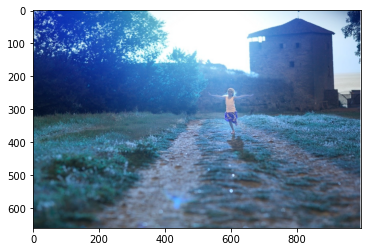

In [5]:
plt.imshow(image)

Note that the color patterns for OpenCV and Matplotlib are not the same (OpenCV uses BGR, while Matplotlib uses RGB). To make the conversion, we can do:

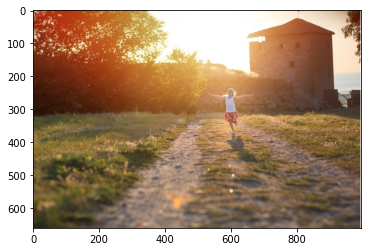

In [6]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)

Nice! Now, the colors are correct. At the same time, colors are hardly important for the analysis of images. Also, considering colors we more features, which may make it harder to fit our model. Thus, we usually work with grayscale images:

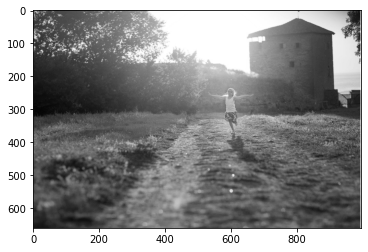

In [7]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap = 'gray')

To see this, we can get the shape of our images:

In [8]:
image.shape

(660, 995, 3)

In [9]:
image_rgb.shape

(660, 995, 3)

In [10]:
image_gray.shape

(660, 995)

Note that the grayscale image only has one channel.

## Extracting regions of interest

In our image, we may want to focus on some Regions of Interest (RoI). This is very important, for instance, when we use face recognition methods. Since our image is nothing more than a matrix with information about pixel location and color, we may try to use slices of this matrix to get the RoI. 

In [11]:
image_rgb_roi = image_rgb[200:400, 500:700]

Let's try to plot our RoI:
plt.imshow(

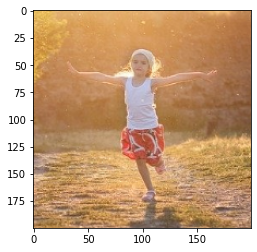

In [12]:
plt.imshow(image_rgb_roi)

Nice! We were able to extract a region of interest from our initial image. Then, for instance, we can save the grayscale format of this new image with:

In [13]:
image_gray_roi = cv2.cvtColor(image_rgb_roi, cv2.COLOR_BGR2GRAY)
cv2.imwrite("image_gray_roi.png", image_gray_roi)

True

To locate this slice in the initial figure, we can do:

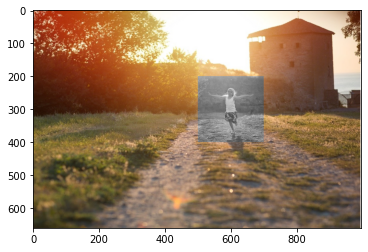

In [14]:
image_gray_roi_rgb = cv2.cvtColor(image_gray_roi, cv2.COLOR_GRAY2RGB)

image_rgb[200:400, 500:700] = image_gray_roi_rgb

plt.imshow(image_rgb)

Nice! We were able to get an image, get a slice of it to get a region of interest, and change its color pattern to grayscale.

# Cascade classifier

To perform our facial recognition, we will use a very popular classifier: the Haar cascade classifier. This is a very efficient algorithm, which receives a gray-scale image and performs a cascade classification. Let's try to use this in a new image:

In [15]:
image_people = cv2.imread("Aula02_00.png")

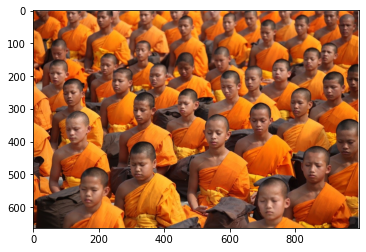

In [16]:
plt.imshow(cv2.cvtColor(image_people, cv2.COLOR_BGR2RGB))

The Haar cascade classifier works with grayscale images. To get the grayscale image, we can do:

In [17]:
image_people_gray = cv2.cvtColor(image_people, cv2.COLOR_BGR2GRAY)

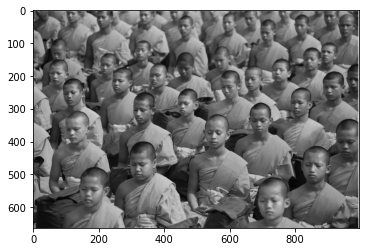

In [18]:
plt.imshow(image_people_gray, cmap = 'gray')

Finally, let's try to perform our classification. First, we instance our classifier:

In [19]:
classifier = cv2.CascadeClassifier("/content/haarcascade-frontalface-default.xml")

Note that, here, we are instancing an already trained classifier. These can be found in the OpenCV open repository:

https://github.com/opencv/opencv/tree/master/data/haarcascades

Now, to make our detection, we can do:

In [20]:
faces = classifier.detectMultiScale(image_people_gray, 1.1, 5)

Here, 1.1 is the rate of image shrinking during the face detection. Also, 5 is the minimum number of neighbor features considered. Let's see how many faces our algorithm identified:

In [21]:
len(faces)

29

Our classifier was able to identify 29 faces. Note that using a lower shrinking rate makes our model more accurate, but also less efficient. Let's understand what are those faces:

In [22]:
faces[0]

array([871, 111,  46,  46], dtype=int32)

Note that, here, we have four values. These values actually represent rectangles in our image, which delimit a face (x, y, width, height). We can draw the rectangles in our image using: 

In [23]:
image_people_annot = image_people.copy( )

for (x, y, w, h) in faces:
  cv2.rectangle(image_people_annot, (x, y), (x + w, y + h), (255, 255, 0), 2)

Now, we can see our annotated image using:

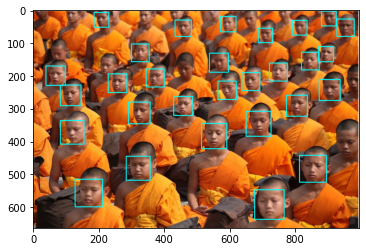

In [24]:
plt.imshow(cv2.cvtColor(image_people_annot, cv2.COLOR_BGR2RGB))

Indeed, we were able to identify most of the faces in our image, but not all of them. Then, we can extract our identified faces using:

In [25]:
face_image = 0

for (x, y, w, h) in faces:
  face_image += 1
  image_people_roi = image_people_annot[y : y + h, x : x + w]
  cv2.imwrite("face_" + str(face_image) + ".png", image_people_roi)

Nice! We can also use this idea to get faces from multiple images. First, let's define some auxiliary functions:

In [26]:
# Reads and obtains the image (in RGB and Grayscale)

def GetImage(img):
  image = cv2.imread(img)
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  return image, image_gray

In [27]:
# Performs the classification and extracts the faces

def GetFaces(classifier, img, img_gray, face_num = 1):
  faces = classifier.detectMultiScale(img_gray, 1.3, 5)

  for (x, y, w, h) in faces:
    image_roi = img[y : y + h, x : x + w]
    cv2.imwrite("faces/01/face_" + str(face_num) + ".png", image_roi)
  
  return faces

Finally, let's perform our classification:

In [28]:
images = ["Aula02_01.png", "Aula02_02.png", "Aula02_03.png"]

face_image = 0

for image in images:
  image_cv2, image_cv2_gray = GetImage(image)

  face_image += 1

  faces = GetFaces(classifier, image_cv2, image_cv2_gray, face_image)

Nice! We were able to make a very simple function to extract the faces from our images, and obtain new files with our desired information.

# Face classification

Ok, we learned how to extract a faces from our figure. Now, we can try to classify our faces, to identify the person it belongs to. This time, we will have to first train a model to do this recognition. Then, we may test it with new faces from different people. For instance, let's get some of our images:

In [29]:
image_face_01 = cv2.imread("s01_01.jpg")
image_face_01 = cv2.cvtColor(image_face_01, cv2.COLOR_BGR2RGB)

image_face_02 = cv2.imread("s02_01.jpg")
image_face_02 = cv2.cvtColor(image_face_02, cv2.COLOR_BGR2RGB)

image_face_03 = cv2.imread("s03_01.jpg")
image_face_03 = cv2.cvtColor(image_face_03, cv2.COLOR_BGR2RGB)

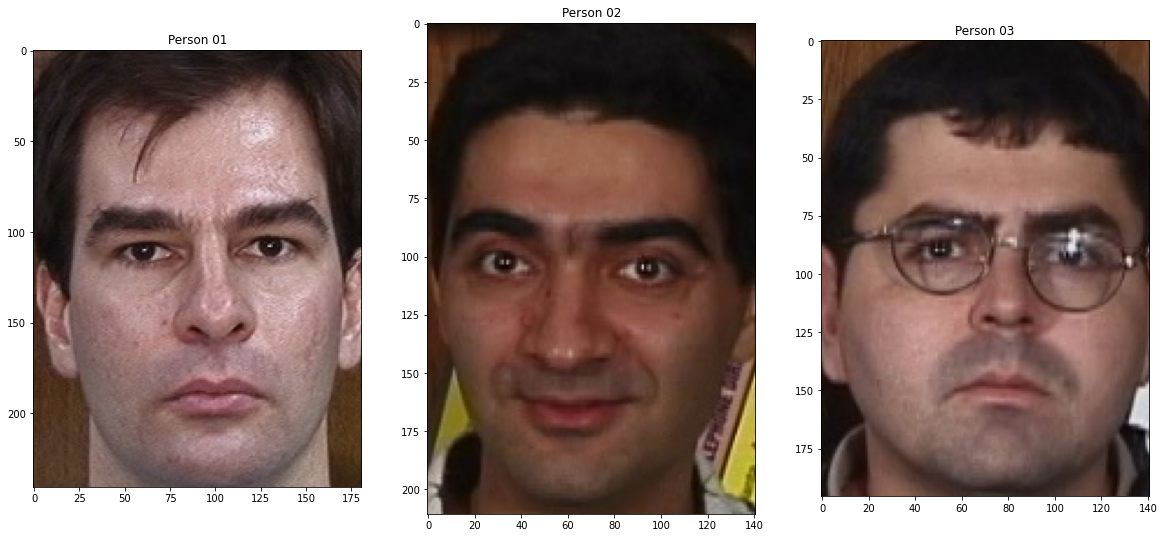

In [30]:
plt.figure(figsize = (20, 10))
plt.subplot(131)
plt.title("Person 01")
plt.imshow(image_face_01)
plt.subplot(132)
plt.title("Person 02")
plt.imshow(image_face_02)
plt.subplot(133)
plt.title("Person 03")
plt.imshow(image_face_03)

Nice! Note that these images show the faces of different people. Also, these images have different sizes. We also have different images for the same people:

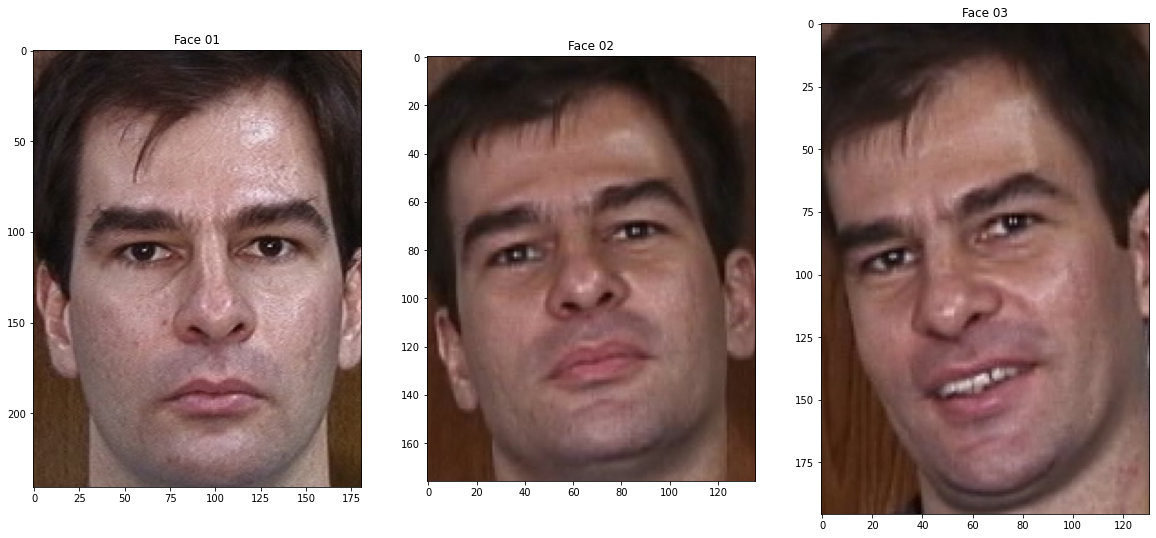

In [31]:
image_face_01 = cv2.imread("s01_01.jpg")
image_face_01 = cv2.cvtColor(image_face_01, cv2.COLOR_BGR2RGB)

image_face_02 = cv2.imread("s01_02.jpg")
image_face_02 = cv2.cvtColor(image_face_02, cv2.COLOR_BGR2RGB)

image_face_03 = cv2.imread("s01_03.jpg")
image_face_03 = cv2.cvtColor(image_face_03, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20, 10))
plt.subplot(131)
plt.title("Face 01")
plt.imshow(image_face_01)
plt.subplot(132)
plt.title("Face 02")
plt.imshow(image_face_02)
plt.subplot(133)
plt.title("Face 03")
plt.imshow(image_face_03)

Note that, since our images have different sizes, each image has a different number of pixels (which are the features of our model). To fit a model, we first have to "normalize" our images, making them have similar size. First, to get the name of all of our files, we can do:

In [32]:
def GetNameImageFiles(path):
  list_faces_files = []

  for f in listdir(faces_path):
    if isfile(join(faces_path, f)):
      list_faces_files.append(f)

  return list_faces_files

Now, to get our figures:

In [33]:
faces_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/Avançado/faces/treino"

list_faces_files_train = GetNameImageFiles(faces_path)

In [34]:
faces_path = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/Avançado/faces/teste"

list_faces_files_test = GetNameImageFiles(faces_path)

Let's see how many figures we have:

In [35]:
len(list_faces_files_train)

500

In [36]:
len(list_faces_files_test)

250

So, we have 500 images for training and 250 for testing, totalizing 750 figures on total. Note that some of our images are different faces from the same people, and this can be understood by the file name. Let's try to obtain this:

In [37]:
def GetFaceIdentifier(face_file):
  person = face_file[1:3]
  number = face_file[4:6]

  return person, number

Now, let's get the identification of our files:

In [38]:
person_train = []
number_train = []
person_test  = []
number_test  = []

for file in list_faces_files_train:
  p, n = GetFaceIdentifier(file)
  person_train.append(p)
  number_train.append(n)

for file in list_faces_files_test:
  p, n = GetFaceIdentifier(file)
  person_test.append(p)
  number_test.append(n)

## Image standardization

Finally, let's standardize our images. Here, we will both reduce the size of our images and change our colors to grayscale. Thus, let's do:

In [39]:
def GetStandardizedImage(face_file):
  image = cv2.imread(face_file, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (200, 200), interpolation = cv2.INTER_LANCZOS4)
  return image

We can get our images using:

In [40]:
train_images = [GetStandardizedImage(f) for f in list_faces_files_train]

In [41]:
test_images = [GetStandardizedImage(f) for f in list_faces_files_test]

Nice! Let's plot some figures and their identification:


Text(0.5, 1.0, '11')

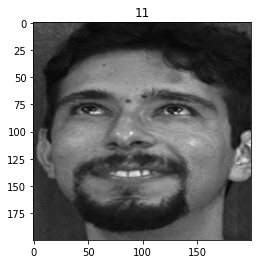

In [42]:
plt.imshow(train_images[101], cmap = 'gray')
plt.title(person_train[101])

Text(0.5, 1.0, '45')

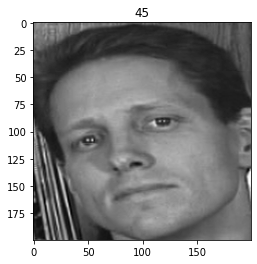

In [43]:
plt.imshow(train_images[433], cmap = 'gray')
plt.title(person_train[433])

Text(0.5, 1.0, '08')

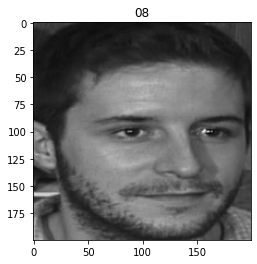

In [44]:
plt.imshow(test_images[62], cmap = 'gray')
plt.title(person_test[62])

Nice! We were able to get all images and their respective label. Now, we can fit a classification model. 

# Face classification

In this course, we will use different face classification methods.

## Eigenfaces

The first classifier that we are going to use is Eigenfaces. The eigenfaces algorithm uses PCA to obtain an "average face" for each user. Then, it evaluates the "distance" from a new face to each of the possible faces. In the end, it chooses the label with the lowest distance. To use this algorithm, we have to guarantee that our list of labels is a numpy array. Thus:

In [45]:
person_train = np.asarray(person_train, dtype = np.int32)
person_test  = np.asarray(person_test, dtype = np.int32)

Now, we can instance our model using:

In [46]:
model_eigenfaces = cv2.face.EigenFaceRecognizer_create( )

...and we can train it with:

In [47]:
model_eigenfaces.train(train_images, person_train)

Nice! Now, let's try to make the prediction of one image:

In [50]:
pred = model_eigenfaces.predict(test_images[6])

pred

(5, 6073.689334933893)

So, our model identified that this is person 5. If we check its label:

In [51]:
person_test[6]

5

Nice! Our model is correct. Let's test one more:

In [54]:
pred = model_eigenfaces.predict(test_images[67])

pred

(7, 5522.550462695816)

In [55]:
person_test[67]

7

Nice! Our algorithm is correct, once again. Let's obtain the accuracy of our algorithm:

In [60]:
y_pred = [model_eigenfaces.predict(img) for img in test_images]

y_pred = np.asarray(y_pred, dtype = np.int32)

In [72]:
acc = (np.equal(y_pred[:, 0], person_test).sum( ))/len(test_images)

print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 72.40%


So, our model returns an accuracy of 72.40%. 

In [70]:
np.equal(y_pred[:, 0], person_test).sum( )

181

In [71]:
len(test_images)

250

## Fisherfaces

Fisherfaces uses the LDA (which is similar to PCA, but tries to maximize the variance from each class). It is usually more robust than eigenfaces. Let's try to fit it:

In [73]:
model_fisherfaces = cv2.face.FisherFaceRecognizer_create( )

Now, to train our model:

In [74]:
model_fisherfaces.train(train_images, person_train)

Now, let's make some tests:

In [76]:
pred = model_fisherfaces.predict(test_images[17])

pred

(3, 844.2712936106093)

In [75]:
person_test[17]

3

Our model was able to get the correct label! Let's evaluate the accuracy of this model:

In [78]:
y_pred = [model_fisherfaces.predict(img) for img in test_images]

y_pred = np.asarray(y_pred, dtype = np.int32)

acc = (np.equal(y_pred[:, 0], person_test).sum( ))/len(test_images)

print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 52.00%


So, actually, the Fisherfaces model behaved word than Eigenfaces, for our case. 

## LBPH

The final model that we will be using here is LBPH. This is considered as the most robust algorithm. Let's instance it and train it:

In [79]:
model_LBPH = cv2.face.LBPHFaceRecognizer_create( )

In [80]:
model_LBPH.train(train_images, person_train)

Nice! Now, let's test it:

In [86]:
pred = model_fisherfaces.predict(test_images[21])

pred

(2, 890.7654895959029)

In [87]:
person_test[21]

2

In [88]:
pred = model_fisherfaces.predict(test_images[27])

pred

(1, 807.984817308255)

In [89]:
person_test[27]

1

Again, our model was able to find the correct label for both cases. Now, evaluating the accuracy:

In [90]:
y_pred = [model_LBPH.predict(img) for img in test_images]

y_pred = np.asarray(y_pred, dtype = np.int32)

acc = (np.equal(y_pred[:, 0], person_test).sum( ))/len(test_images)

print("Accuracy: {:.2f}%".format(acc*100))

Accuracy: 79.20%


Nice! Our LBPH model actually got the highest accuracy! Almost 80%.

# Extracting facial marks

Ok, we saw how to extract faces from images, and perform classifications with these faces. Now, we will go further into the extraction of facial marks: obtaining eyes, mouth, nose, and others. Here, we will use Dlib. First, let's get an image to work on:

In [93]:
image = cv2.imread("/content/faces/03/px-woman-smilings.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

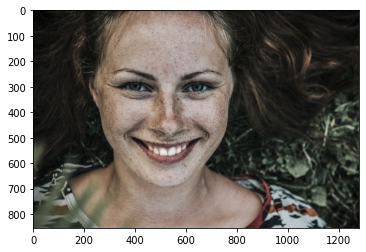

In [94]:
plt.imshow(image)

Now, let's instance a Dlib classifier:

In [99]:
dlib_fitted_classifier = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/Avançado/classifier/shape_predictor_68_face_landmarks.dat"
dlib_classifier = dlib.shape_predictor(dlib_fitted_classifier)
detector_face = dlib.get_frontal_face_detector()

Before obtaining the facial marks, let's make a function to get the annotation of the recognized face:

In [103]:
def DetectFace(image):
  rec =  detector_face(image, 1)

  if len(rec) == 0:
    return None

  for k, d in enumerate(rec):
    cv2.rectangle(image, (d.left( ), d.top( )), (d.right( ), d.bottom( )), (255, 255, 0), 2)

  return image

Ok. Now, let's get the annotated image:

In [104]:
annot_image = image.copy( )

annot_image = DetectFace(annot_image)

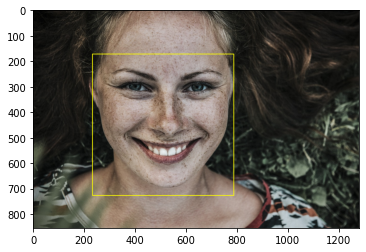

In [105]:
plt.imshow(annot_image)

Ok, we were able to find the face. Now, to get the facial marks:

In [110]:
def GetFacialMarks(image):
  rec =  detector_face(image, 1)

  if len(rec) == 0:
    return None

  marks = []

  for r in rec:
    marks.append(np.matrix([[p.x, p.y] for p in dlib_classifier(image, r).parts( )]))

  return marks

In [111]:
marks = GetFacialMarks(image)

Ok. Now, we can investigate our facial marks. First, let's get the length of our feature:

In [112]:
len(marks)

1

This is the number of faces we have found. Now, if we do:

In [113]:
len(marks[0])

68

We got 68 facial marks in this face. Now, let's plot these marks in the face:

In [115]:
def PlotFacialMarks(image, marks):
  for mark in marks:
    for idx, dot in enumerate(mark):
      center = (dot[0, 0], dot[0, 1])
      cv2.circle(image, center, 3, (255, 255, 0), -1)
      cv2.putText(image, str(idx), center, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

  return image

In [116]:
annot_image = image.copy( )
annot_image = PlotFacialMarks(annot_image, marks)

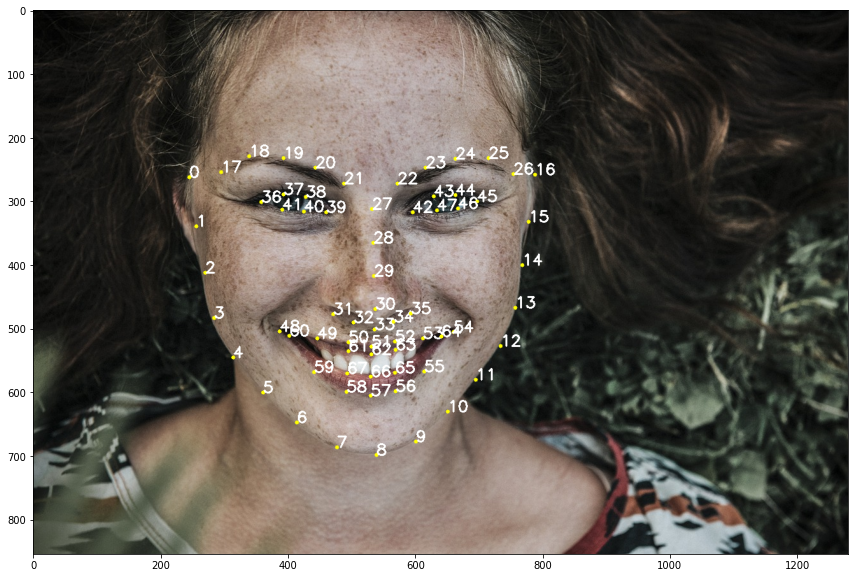

In [119]:
plt.figure(figsize = (20, 10))
plt.imshow(annot_image)

Nice! Note that the facial marks where able to identify the location of the eyes, eyebrows, chin, mouth, nose, and others. Since we have made a function, we can now test it in another image, such as:

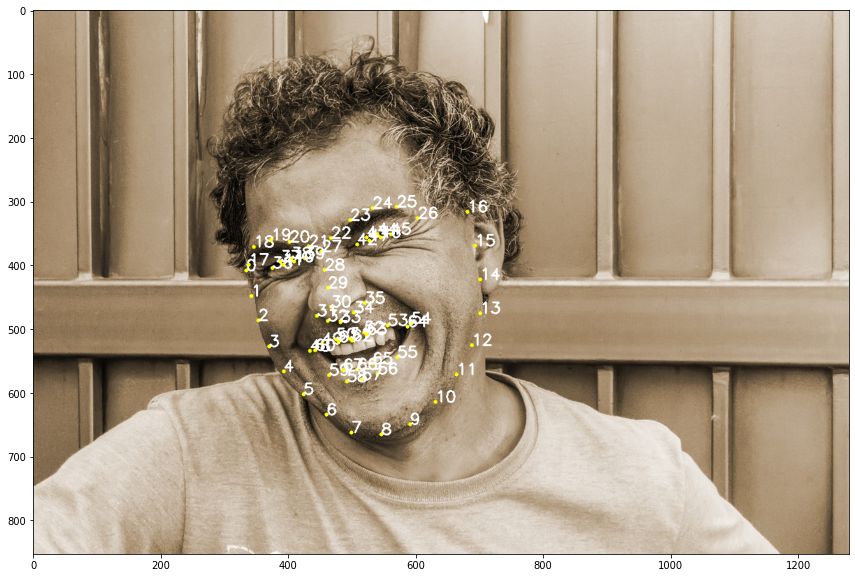

In [121]:
image = cv2.imread("/content/faces/03/px-man-happy.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

marks = GetFacialMarks(image)
annot_image = image.copy( )
annot_image = PlotFacialMarks(annot_image, marks)

plt.figure(figsize = (20, 10))
plt.imshow(annot_image)

Nice! Once again, we managed to get the facial marks from our image.

## Aspect-ratio measures

To use the facial marks to understand what is happening (if the person is smiling, angry, or laughing, for instance), we should create aspect-ratio measures. This helps to create adimensional metrics, which do not depending on the image "zoom". First, let's get the marks related to each face object:

In [122]:
FACE = list(range(17, 68))
FACE_COMPLETA = list(range(0, 68))
LABIO = list(range(48, 61))
SOMBRANCELHA_DIREITA = list(range(17, 22))
SOMBRANCELHA_ESQUERDA = list(range(22, 27))
OLHO_DIREITO = list(range(36, 42))
OLHO_ESQUERDO = list(range(42, 48))
NARIZ = list(range(27, 35))
MANDIBULA = list(range(0, 17))

Now, to get the aspect ratio metric:

In [125]:
def AspectRatioEyes(eyes_marks):
  a = dist.euclidean(eyes_marks[1], eyes_marks[5])
  b = dist.euclidean(eyes_marks[2], eyes_marks[4])
  c = dist.euclidean(eyes_marks[0], eyes_marks[3])

  aspect_ratio = (a + b)/(2.0 * c)

  return aspect_ratio

In [131]:
left_eye = AspectRatioEyes(marks[0][OLHO_ESQUERDO])

In [132]:
right_eye = AspectRatioEyes(marks[0][OLHO_DIREITO])

In [133]:
print(f"Left eye: {left_eye}")
print(f"Right eye: {right_eye}")

Left eye: 0.12169073046467273
Right eye: 0.12044973520917499


We can use these aspect ratio metrics to say whether the person has closed or opened eyes, which may say something about their humour.

# Working with videos

When we work with videos using OpenCV, we should understand that videos are, basically, collections of images. Thus, we can use very similar methods. Let's create some functions to help us to work with these types of data:

In [138]:
def StandardizeImage(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame = cv2.resize(frame, (500, 400))

  return frame

In [142]:
def ShowVideo(frame):
  img = Img.fromarray(frame, "RGB")
  buffer = BytesIO( )
  img.save(buffer, format = "JPEG")
  display(Image(data = buffer.getvalue( )))
  clear_output(wait = True)

In [143]:
video = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Avançado/videos/expressoes.mov")

In [144]:
try:
  while(True):
    capture_Ok, frame = video.read( )
    if capture_Ok:
      frame = StandardizeImage(frame)
      ShowVideo(frame)
except KeyboardInterrupt:
  video.release( )
  print("Stopped")

Stopped


Nice! With this code, we see the video in Jupyter notebook.

## Obtaining information from the video

Now, let's try to get information from the video. Here, we will evaluate an aspect-ratio metric for the mouth, to understand whether the mouth is opened or closed. To define this metric, we can do:

In [145]:
def AspectRatioMouth(mouth_marks):
  a = dist.euclidean(mouth_marks[3], mouth_marks[9])
  b = dist.euclidean(mouth_marks[2], mouth_marks[10])
  c = dist.euclidean(mouth_marks[4], mouth_marks[8])
  d = dist.euclidean(mouth_marks[0], mouth_marks[6])

  aspect_ratio = (a + b + c)/(3*d)

  return aspect_ratio

Also, let's define a convex hull function to draw the mouth:

In [146]:
def GetConvexHullMouth(image, marks):
  rec = detector_face(image, 1)

  if len(rec) == 0:
    return None

  for idx, ret in enumerate(rec):
    mark = marks[idx]

    dots = cv2.convexHull(mark[LABIO])
    cv2.drawContours(image, [dots], 0, (0, 255, 0), 2)

  return image

Finally, let's we can open the video once again. This time, we will get the facial marks at each frame, and evaluate the aspect ratio. Then, we will get the maximum aspect ratio seem in the video:

In [148]:
video = cv2.VideoCapture("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Avançado/videos/bocejo.mov")

try:
  ar_max = 0
  while(True):
    capture_Ok, frame = video.read( )
    if capture_Ok:
      frame = StandardizeImage(frame)
      marks = GetFacialMarks(image)

      if marks is not None:

        ar_mouth = round(AspectRatioMouth(marks[0][LABIO]), 3)

        if ar_mouth > ar_max:
          ar_max = ar_mouth

        info = "mouth " + str(ar_mouth) + " max " + str(ar_max)

        frame = GetConvexHullMouth(frame, marks)

        cv2.putText(frame, info, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

      ShowVideo(frame)
except KeyboardInterrupt:
  video.release( )
  print("Stopped")

Stopped


Nice! It worked out.